In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import json

# Extended professional palette
colors = {
    'Greedy_Worst': '#E6194B',  # Red
    'Edf': '#FF7F00',  # Orange
    'Greedy_Green': '#3CB44B',  # Green
    'MILP': '#4363D8',  # Blue
    'RR': '#911EB4',  # Purple
    'Sjf': '#FFD700',  # Gold
}

mode = 'space_time'
schedules_path = f'../schedules/{mode}/'
graphs_output = f'../graphing/graphs/{mode}/'
schedules = {
    'Edf': pd.read_csv(f'{schedules_path}edf.csv'),
    'Greedy_Worst': pd.read_csv(f'{schedules_path}worst.csv'),
    'Greedy_Green': pd.read_csv(f'{schedules_path}green.csv'),
    'MILP': pd.read_csv(f'{schedules_path}milp_green.csv'),
    'RR': pd.read_csv(f'{schedules_path}rr.csv'),
    'Sjf': pd.read_csv(f'{schedules_path}sjf.csv'),
}

associations_df = pd.read_csv('../data/associations_df.csv')
forecasts_df = pd.read_csv('../data/forecast_data.csv')

shift_in_time_traceroute = "../config/traceroutes/onesource/"
shift_in_space_traceroute = "../config/traceroutes/many_sources_to_one_transfer_node/"


In [64]:
traceroute_map = {}
if mode == 'time':
    files = os.listdir(shift_in_space_traceroute)
else:
    files = os.listdir(shift_in_space_traceroute)

for file in files:
    node_name = file.split('_')[0]
    joined_path = os.path.join(shift_in_space_traceroute, file)
    with open(joined_path, 'r') as f:
        output = json.load(f)
        traceroute_list = []
        for key, value in output.items():
            traceroute_list.append(key)
        traceroute_map[node_name] = traceroute_list


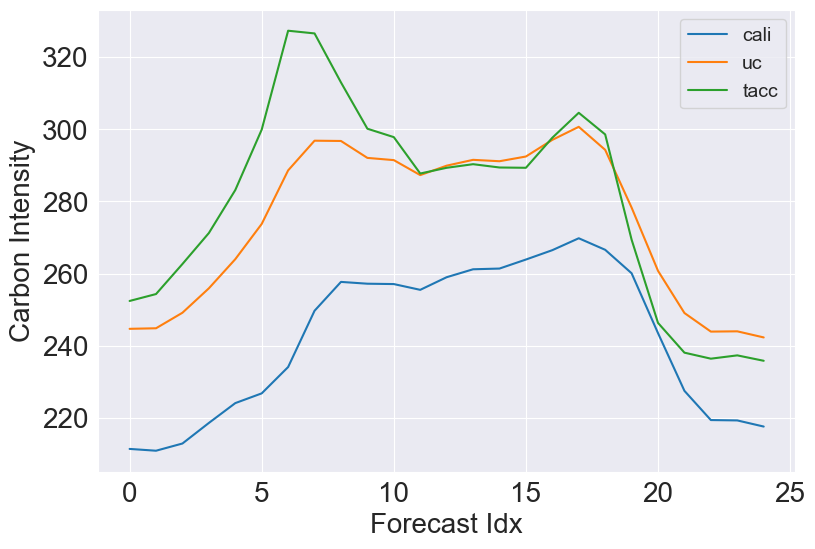

In [65]:
traceroute = traceroute_map['jgoldverg@gmail.com-cali'][:-3]
cali_mean_forecast = forecasts_df[(forecasts_df['node_id'] == 'jgoldverg@gmail.com-cali') & (forecasts_df['ip'].isin( traceroute_map['jgoldverg@gmail.com-cali'][:-3]))].groupby('forecast_idx')['ci'].mean()
uc_mean_forecast = forecasts_df[(forecasts_df['node_id'] == 'jgoldverg@gmail.com-ccuc') & (forecasts_df['ip'].isin( traceroute_map['jgoldverg@gmail.com-ccuc'][:-3]))].groupby('forecast_idx')['ci'].mean()
tacc_mean_forecast = forecasts_df[(forecasts_df['node_id'] == 'jgoldverg@gmail.com-tacc') & (forecasts_df['ip'].isin( traceroute_map['jgoldverg@gmail.com-tacc'][:-3]))].groupby('forecast_idx')['ci'].mean()

plt.figure(figsize=(9,6))
plt.plot(cali_mean_forecast, label='cali')
plt.plot(uc_mean_forecast, label='uc')
plt.plot(tacc_mean_forecast, label='tacc')
plt.xlabel("Forecast Idx", fontsize=20)
plt.ylabel("Carbon Intensity", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.savefig(f"{graphs_output}24hour_forecast_plot.pdf", format='pdf', dpi=800)
plt.show()


/var/folders/rn/lb6d61xx4_j9fhhnzl_6wkk40000gn/T/ipykernel_58468/3510647484.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Size (GB)', data=df,
/var/folders/rn/lb6d61xx4_j9fhhnzl_6wkk40000gn/T/ipykernel_58468/3510647484.py:23: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(x='Type', y='Size (GB)', data=df,


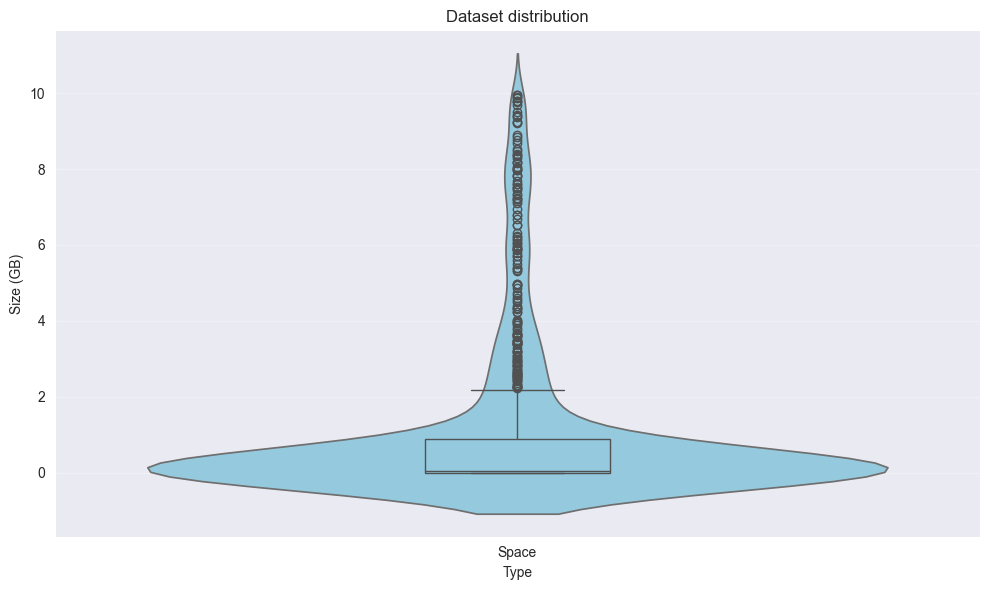

In [67]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load data
with open('../config/jobs_config/1000_jobs.json', 'r') as f:
    data_space = json.load(f)

# with open('../config/jobs_config/150_jobs.json') as f:
#     data_time = json.load(f)

# Extract job sizes and convert to GB
job_sizes_space = [item['bytes'] / (1024 ** 3) for item in data_space]
# job_sizes_time = [item['bytes'] / (1024 ** 3) for item in data_time]

# Prepare DataFrame
df = pd.DataFrame({
    'Size (GB)': job_sizes_space ,
    'Type': ['Space']*len(job_sizes_space)
})

plt.figure(figsize=(10, 6))
sns.violinplot(x='Type', y='Size (GB)', data=df,
               palette=['skyblue', 'salmon'], inner=None)
sns.boxplot(x='Type', y='Size (GB)', data=df,
            width=0.2, boxprops={'facecolor':'none'})

plt.title('Dataset distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{graphs_output}violin_jobs.pdf", format='pdf',dpi=800)
plt.show()

# Calculate totals
total_space_gb = sum(job_sizes_space)
# print(f'Total space workload size: {tsotal_space_gb:.2f} GB')
# print(f'Total time workload size: {total_time_gb:.2f} GB')

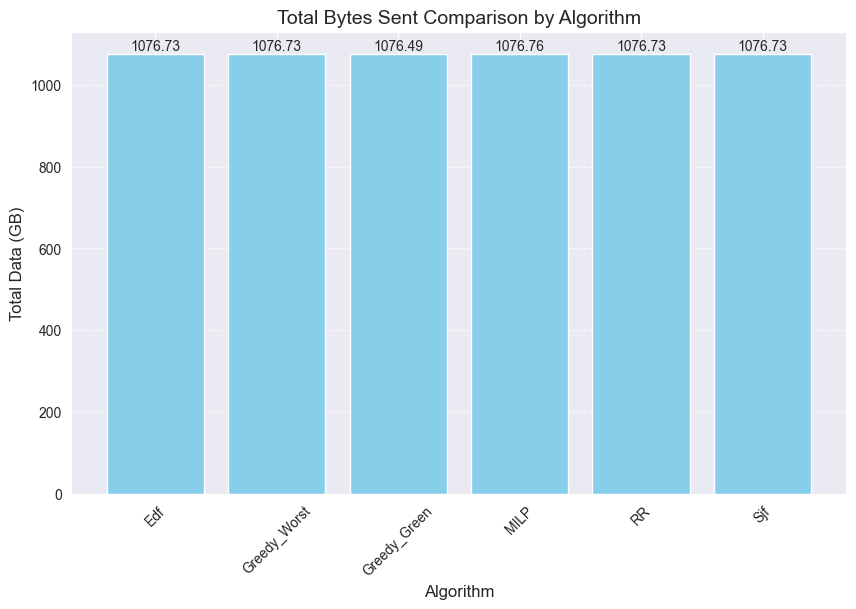

In [84]:
algo_totals = {}
times_used = {}
for algo, df in schedules.items():
    for key, row in df.iterrows():
        bytes_sent = total_gb = (row['throughput'] * row['allocated_time']) / (8 * 1024**3)
        algo_totals[algo] = algo_totals.get(algo,0) + bytes_sent
        times_used[algo] = times_used.get(algo,0) + row['allocated_time']

algos = list(algo_totals.keys())
values = list(algo_totals.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(algos, values, color='skyblue')

# Customize
plt.xlabel("Algorithm", fontsize=12)
plt.ylabel("Total Data (GB)", fontsize=12)
plt.title("Total Bytes Sent Comparison by Algorithm", fontsize=14)
plt.xticks(rotation=45)  # Rotate long algo names
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2f}",
             ha='center', va='bottom')

plt.show()

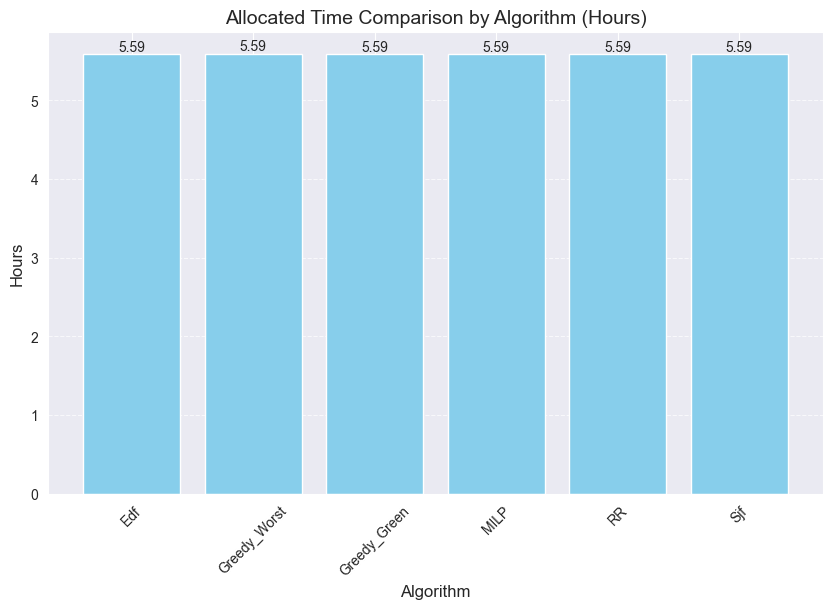

In [90]:

algos = list(times_used.keys())
values = list(times_used.values())
values = [val/3600 for val in values]
plt.figure(figsize=(10, 6))
bars = plt.bar(algos, values, color='skyblue')

# Customize
plt.xlabel("Algorithm", fontsize=12)
plt.ylabel("Total Data (GB)", fontsize=12)
plt.title("Allocated Time Comparison by Algorithm (Hours)", fontsize=14)
plt.xticks(rotation=45)  # Rotate long algo names
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2f}",
             ha='center', va='bottom')

plt.show()

Edf      total emissions: 734.08 gCO2
Greedy_Worst total emissions: 1,653.11 gCO2
Greedy_Green total emissions: 745.48 gCO2
MILP     total emissions: 8.36 gCO2
RR       total emissions: 947.28 gCO2
Sjf      total emissions: 734.08 gCO2


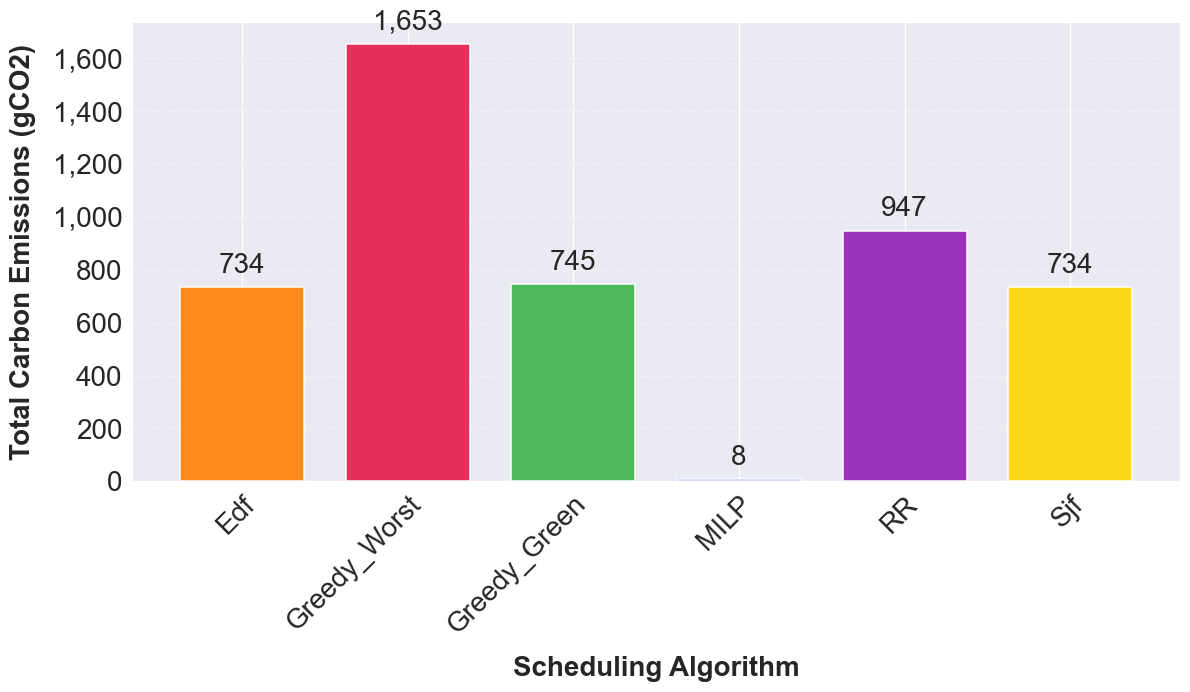

In [91]:
def total_emissions_schedule(schedule_df, schedule_name):
    """Calculate and print total carbon emissions for a schedule"""
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name:8} total emissions: {total:,.2f} gCO2")
    return total


def plot_algorithm_emissions_comparison():
    """
    Compare carbon emissions across scheduling algorithms with enhanced visualization

    Args:
        save_path: Path to save the output figure
    """
    # Calculate totals
    algorithm_names = []
    emission_totals = []

    for algo_name, df in schedules.items():
        if algo_name in colors:  # Only process if we have a color defined
            total = total_emissions_schedule(df, algo_name)
            algorithm_names.append(algo_name)
            emission_totals.append(total)

    # Create figure with professional styling
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Create bars with consistent ordering
    bars = ax.bar(algorithm_names, emission_totals,
                  color=[colors[algo] for algo in algorithm_names],
                  width=0.75, edgecolor='white', linewidth=1.2, alpha=0.9)

    # Customize axes and labels
    ax.set_xlabel("Scheduling Algorithm", fontsize=20, labelpad=12, fontweight='bold')
    ax.set_ylabel("Total Carbon Emissions (gCO2)", fontsize=20, labelpad=12, fontweight='bold')
    # ax.set_title("Carbon Efficiency of Scheduling Algorithms",
    #             fontsize=14, pad=20, fontweight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=20)
    plt.yticks(fontsize=20)
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        offset = max(emission_totals) * 0.02  # Dynamic offset based on max value
        ax.text(bar.get_x() + bar.get_width() / 2., height + offset,
                f'{height:,.0f}',
                ha='center', va='bottom',
                fontsize=20)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)

    # Clean up chart borders
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{graphs_output}algorithm_comparison.pdf', format='pdf', dpi=800, bbox_inches='tight')
    plt.show()


# Example usage
plot_algorithm_emissions_comparison()

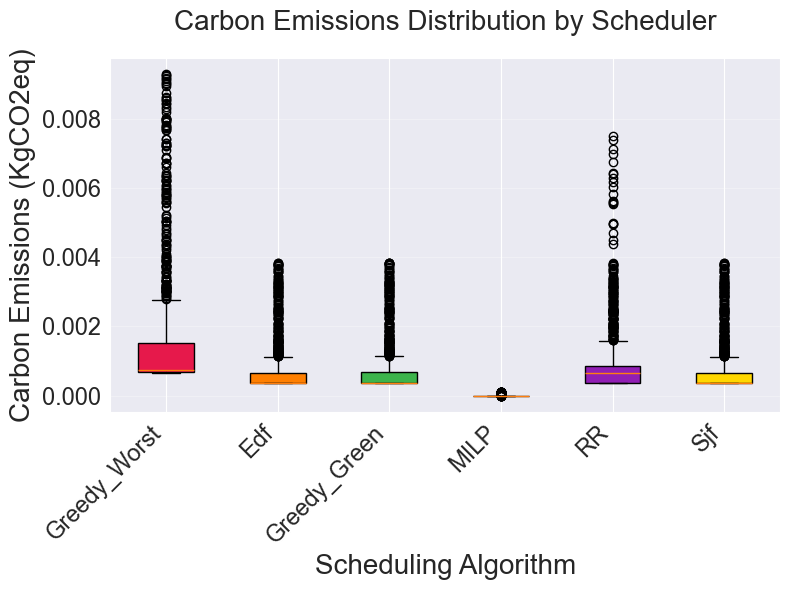

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Prepare Plot Data
# ==================================================
data = []
labels = []
for planner in colors.keys():
    if planner in schedules:
        data.append(schedules[planner]['carbon_emissions'] / 1000)
        labels.append(planner)

# 3. Create Basic Boxplot
# ==================================================
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Create boxplot
boxplot = ax.boxplot(
    data,
    labels=labels,
    patch_artist=True,  # Enable color filling
    showfliers=True
)

# Apply colors
for patch, color in zip(boxplot['boxes'], colors.values()):
    patch.set_facecolor(color)

# Formatting
ax.set_xlabel('Scheduling Algorithm', fontsize=20)
ax.set_ylabel('Carbon Emissions (KgCO2eq)', fontsize=20)
ax.set_title('Carbon Emissions Distribution by Scheduler', fontsize=20, pad=20)
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right', fontsize=17)
plt.yticks(fontsize=17)

# 4. Save and Show
# ==================================================
plt.tight_layout()
plt.savefig(f'{graphs_output}boxplot_algos.pdf', format='pdf', dpi=800, bbox_inches='tight')
plt.show()

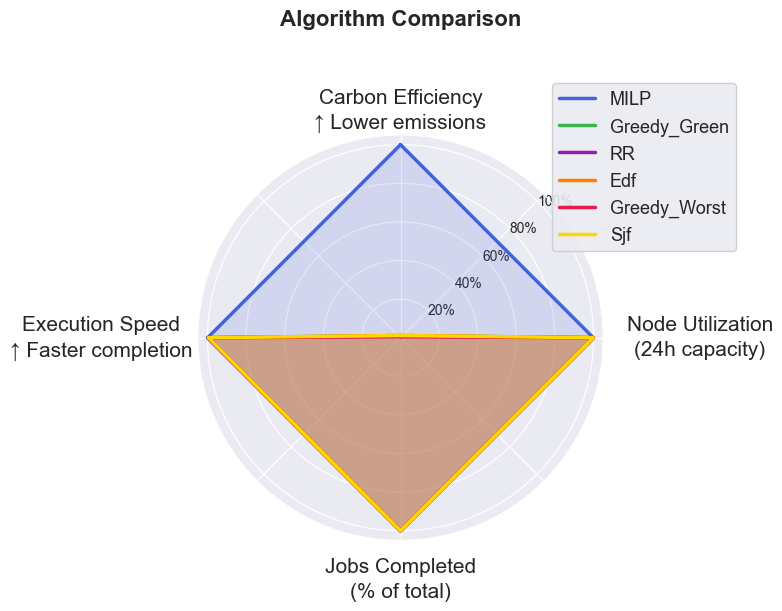

In [70]:
from math import pi


def create_radar_chart(schedule_files, title="Algorithm Comparison"):
    # Load and process data
    metrics = {}
    total_jobs = len(pd.read_csv(next(iter(schedule_files.values())))['job_id'].unique())
    max_hours = 24  # Maximum utilization per node (24 hours)

    for algo, filepath in schedule_files.items():
        df = pd.read_csv(filepath)
        completed_jobs = df['job_id'].nunique()

        # Calculate metrics
        total_allocated_hours = df['allocated_time'].sum() / 3600
        utilization_pct = (total_allocated_hours / max_hours) * 100

        metrics[algo] = {
            '1_Carbon': 1 / (df['carbon_emissions'].sum() + 1e-6),
            '2_Utilization': utilization_pct,
            '3_Completion': (completed_jobs / total_jobs) * 100,
            '4_Speed': 1 / df['allocated_time'].mean()
        }

    # Normalize and cap metrics
    metrics_df = pd.DataFrame(metrics).T
    normalized_df = (metrics_df / metrics_df.max()).clip(upper=1.0)

    # Prepare radar coordinates
    categories = sorted(metrics_df.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Create figure with optimized layout
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'polar': True},
                           constrained_layout=True)

    # Configure polar plot
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.ylim(0, 1.05)  # Slight buffer above 100%

    # Custom label properties
    label_properties = {
        '1_Carbon': {
            'text': 'Carbon Efficiency\n↑ Lower emissions',
            'pad': 1.18,
            'ha': 'center',
            'rotation': 90  # Degrees
        },
        '2_Utilization': {
            'text': 'Node Utilization\n(24h capacity)',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 0
        },
        '3_Completion': {
            'text': 'Jobs Completed\n(% of total)',
            'pad': 1.25,
            'ha': 'center',
            'rotation': 270
        },
        '4_Speed': {
            'text': 'Execution Speed\n↑ Faster completion',
            'pad': 1.55,
            'ha': 'center',
            'rotation': 180
        }
    }

    # Add metric labels with precise positioning
    for angle, category in zip(angles[:-1], categories):
        props = label_properties[category]
        ax.text(
            angle, props['pad'], props['text'],
            ha=props['ha'], va='center',
            fontsize=15,
            linespacing=1.4,
            rotation=angle * 180 / pi - 90 + props['rotation'],
            rotation_mode='anchor'
        )

    # Configure radial grid
    ax.set_rgrids(
        [0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["20%", "40%", "60%", "80%", "100%"],
        angle=45,
        fontsize=10,
        verticalalignment='center'
    )

    ax.set_xticklabels([])
    # Plot each algorithm's data

    for algo in normalized_df.index:
        values = normalized_df.loc[algo].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[algo], linewidth=2.5, label=algo)
        ax.fill(angles, values, color=colors[algo], alpha=0.15)

    # Add title and legend
    plt.title(title, y=1.25, fontsize=16, weight='bold')
    plt.legend(
        loc='upper right',
        bbox_to_anchor=(1.35, 1.15),
        framealpha=0.9,
        fontsize=13
    )

    # Save as high-quality PDF
    plt.savefig(
        f'{graphs_output}/comparison_algos_radar.pdf',
        format="pdf",
        dpi=800,
        bbox_inches='tight',
        transparent=True
    )
    plt.show()


# Example usage
schedule_files = {
    'MILP': f'{schedules_path}milp_green.csv',
    'Greedy_Green': f'{schedules_path}green.csv',
    'RR': f'{schedules_path}rr.csv',
    'Edf': f'{schedules_path}edf.csv',
    'Greedy_Worst': f'{schedules_path}worst.csv',
    'Sjf': f'{schedules_path}sjf.csv'
}

create_radar_chart(schedule_files)

1076.7294270079583
{'Edf': 1076.7294270079583, 'Greedy_Worst': 1076.7294270079583, 'Greedy_Green': 1076.48936345475, 'MILP': 1076.7598860646988, 'RR': 1076.7294270079583, 'Sjf': 1076.7294270079583}


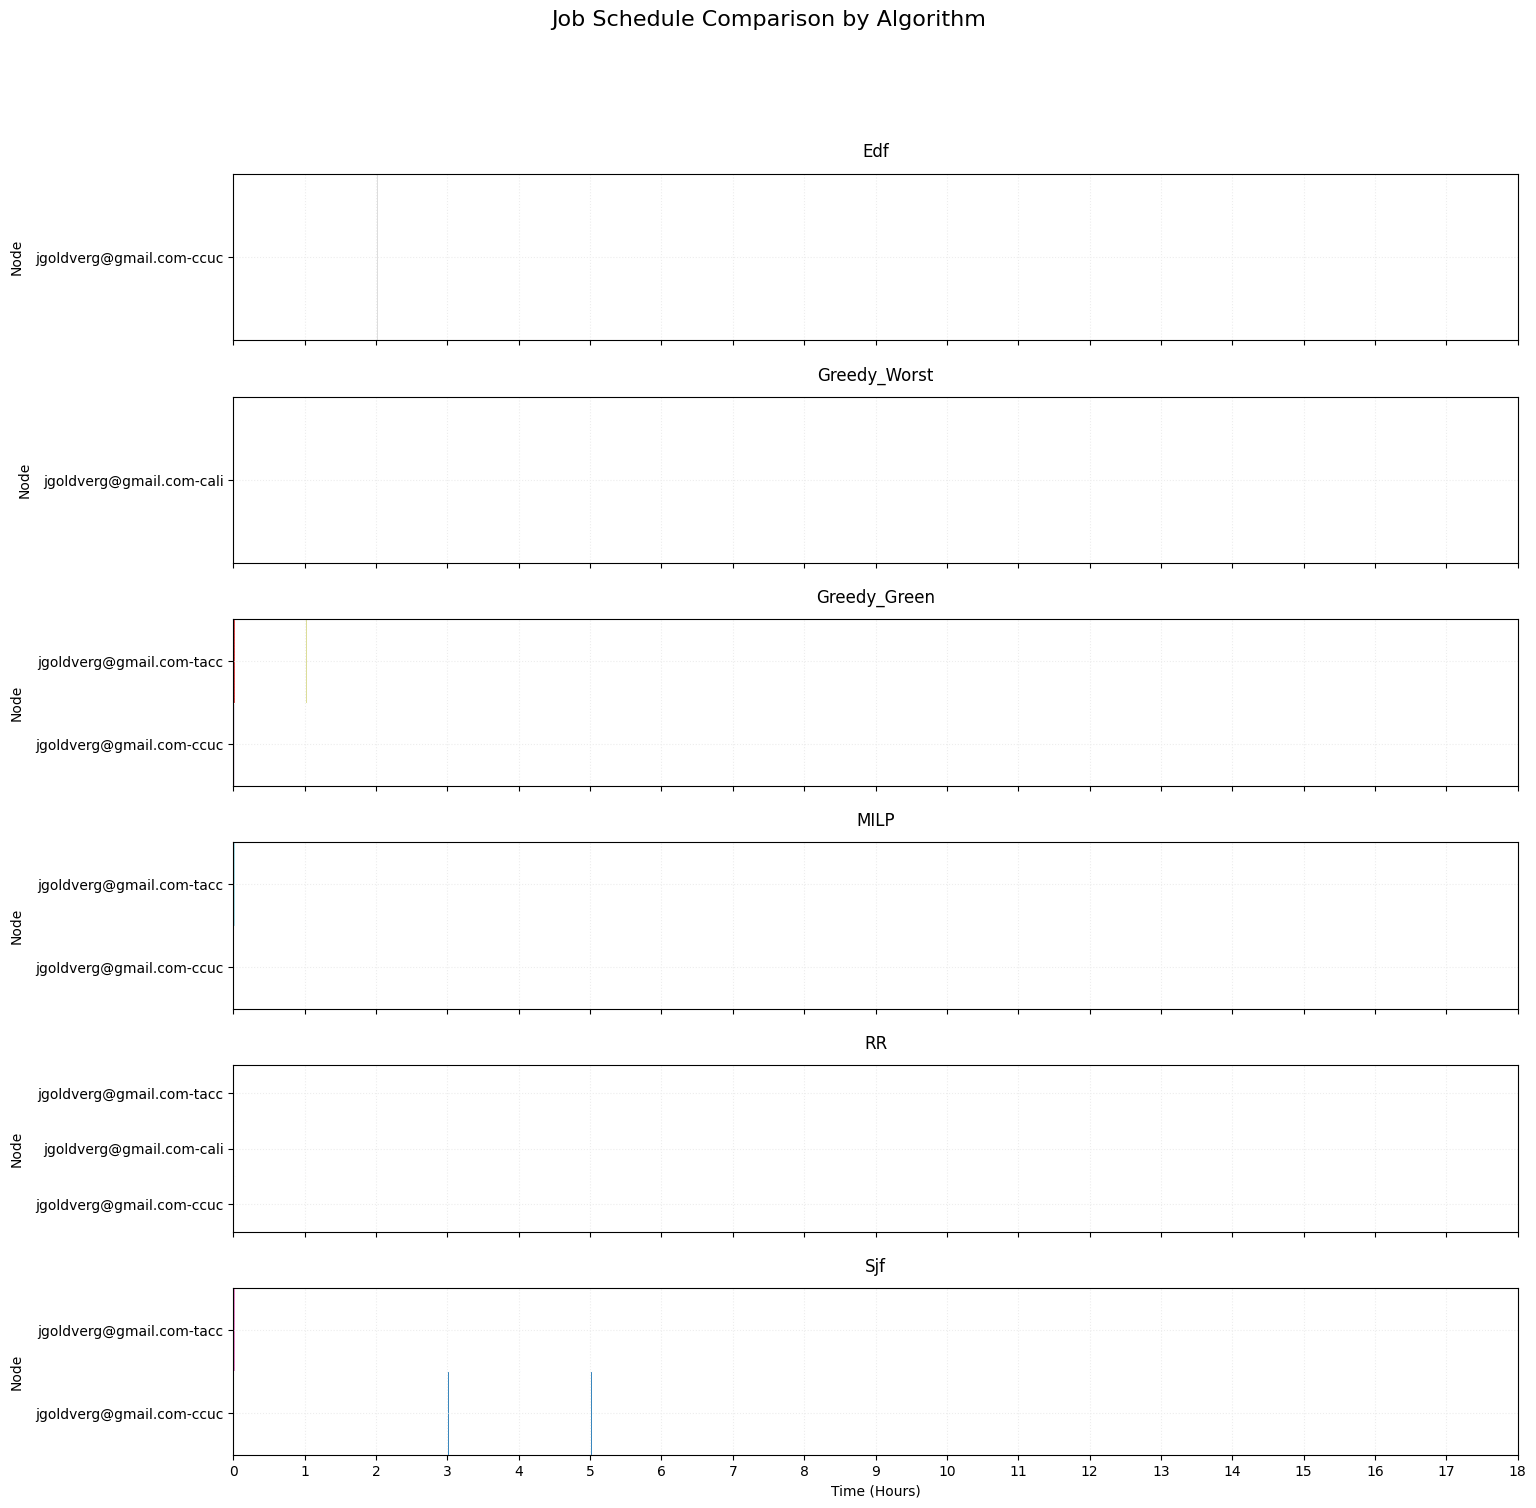

In [105]:
from matplotlib.patches import Patch


def create_clean_gantt(schedules):
    """
    Create a clean Gantt chart with increased row height
    """
    # Combine all data to establish consistent colors
    all_data = pd.concat([df.assign(Algorithm=algo) for algo, df in schedules.items()])

    # Create universal job color mapping
    jobs = sorted(all_data['job_id'].unique())
    cmap = plt.get_cmap('tab20', len(jobs))
    job_colors = {job: cmap(i) for i, job in enumerate(jobs)}

    # Setup figure with clean style
    plt.style.use('default')
    plt.rcParams.update({
        'axes.grid': True,
        'grid.color': '#EDEDED',
        'grid.linestyle': ':',
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10
    })

    n_algorithms = len(schedules)
    # Increased figure height (2.5 inches per row instead of 1.0)
    fig, axes = plt.subplots(n_algorithms, 1, figsize=(16, 2.5 * n_algorithms), sharex=True)
    fig.suptitle('Job Schedule Comparison by Algorithm', fontsize=16, y=1.02)

    # Get max forecast hour across all schedules
    max_hour = max(df['forecast_id'].max() for df in schedules.values()) + 1

    # Process each algorithm
    for i, (ax, (algo, df)) in enumerate(zip(axes, schedules.items())):
        # Plot each job with increased bar height (1.0 instead of 0.7)
        for _, row in df.iterrows():
            duration_hours = row['allocated_time'] / 3600

            ax.barh(
                y=row['node'],
                width=duration_hours,
                left=row['forecast_id'],
                height=1.0,  # Increased bar height
                color=job_colors[row['job_id']],
                edgecolor='white',
                linewidth=0.8,
            )

        # Subplot formatting with increased spacing
        ax.set_title(algo, pad=12)  # Increased padding
        ax.set_ylabel('Node', labelpad=8)  # Added label padding

        # Adjust y-axis ticks to center them better
        nodes = df['node'].unique()
        ax.set_yticks(range(len(nodes)))
        ax.set_yticklabels(nodes)
        ax.set_ylim(-0.5, len(nodes)-0.5)  # Better centering

        # Only show x-axis label on bottom plot
        if i == n_algorithms - 1:
            ax.set_xlabel('Time (Hours)')
        else:
            ax.set_xlabel('')

        # Set consistent x-axis
        ax.set_xlim(0, max_hour)
        ax.set_xticks(np.arange(0, max_hour + 1, 1))
        ax.set_xticklabels([f"{int(x)}" for x in np.arange(0, max_hour + 1, 1)])

    # Create unified legend
    legend_elements = [Patch(color=job_colors[job], label=f'Job {job}') for job in jobs]
    # fig.legend(
    #     handles=legend_elements,
    #     loc='upper right',
    #     bbox_to_anchor=(0.99, 0.99),
    #     title='Job IDs',
    #     fontsize=10,
    #     title_fontsize=11,s
    #     ncol=min(4, len(jobs)))

    plt.tight_layout(pad=3.0, h_pad=1.5)  # Increased spacing between subplots
    plt.savefig(f'{graphs_output}/clean_gantt_comparison_algos.pdf',
                format="pdf",
                dpi=800,
                bbox_inches='tight')
    plt.show()

create_clean_gantt(schedules)

In [106]:
schedules_space = {
    'Edf': pd.read_csv(f'../schedules/big_job_schedules/space/edf_schedule.csv'),
    'GW': pd.read_csv(f'../schedules/big_job_schedules/space/carbon_aware_max_case.csv'),
    'GG': pd.read_csv(f'../schedules/big_job_schedules/space/carbon_aware_min_case.csv'),
    'MILP': pd.read_csv(f'../schedules/big_job_schedules/space/milp_green.csv'),
    'RR': pd.read_csv(f'../schedules/big_job_schedules/space/round_robin_schedule.csv'),
    'Sjf': pd.read_csv(f'../schedules/big_job_schedules/space/sjf_schedule.csv'),
}

schedules_time = {
    'Edf': pd.read_csv(f'../schedules/big_job_schedules/time/edf_schedule.csv'),
    'GW': pd.read_csv(f'../schedules/big_job_schedules/time/carbon_aware_max_case.csv'),
    'GG': pd.read_csv(f'../schedules/big_job_schedules/time/carbon_aware_min_case.csv'),
    'MILP': pd.read_csv(f'../schedules/big_job_schedules/time/milp_green.csv'),
    'RR': pd.read_csv(f'../schedules/big_job_schedules/time/round_robin_schedule.csv'),
    'Sjf': pd.read_csv(f'../schedules/big_job_schedules/time/sjf_schedule.csv'),
}

# Calculate total emissions for each policy in both space and time
def calculate_total_emissions(schedules_dict):

    return {policy: df['carbon_emissions'].sum()
            for policy, df in schedules_dict.items()}

space_emissions = calculate_total_emissions(schedules_space)
time_emissions = calculate_total_emissions(schedules_time)

# Get the list of policies (assuming all dicts have same keys)
policies = list(schedules_space.keys())

# Set up the plot
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = np.arange(len(policies))

# Create bars
space_bars = plt.bar(x - bar_width/2, [space_emissions[p] for p in policies],
                    bar_width, label='Space', color='#1f77b4')
time_bars = plt.bar(x + bar_width/2, [time_emissions[p] for p in policies],
                   bar_width, label='Time', color='#ff7f0e')

# Add labels and title
plt.xlabel('Scheduling Policy', fontsize=15)
plt.ylabel('Total Carbon Emissions', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Comparison of Total Carbon Emissions by Scheduling Policy', fontsize=15)
plt.xticks(x, policies)
plt.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom')

add_labels(space_bars)
add_labels(time_bars)

plt.tight_layout()
plt.show()
plt.savefig('graphs/space_time_grouped_bar.pdf', format='pdf', dpi=800)


FileNotFoundError: [Errno 2] No such file or directory: '../schedules/big_job_schedules/space/edf_schedule.csv'

In [55]:
total_time = 3600 * 25
milp_df = schedules['MILP']
allocated_time = milp_df['allocated_time'].sum()
print(allocated_time)
print(allocated_time / total_time)

algo_utilization = {}
for key, df in schedules.items():
    allocated_time = df['allocated_time'].sum()
    utilization = (allocated_time / total_time) * 100
    algo_utilization[key] = utilization

print(algo_utilization)

14705.783852493561
0.16339759836103956
{'Edf': 16.30921629428966, 'Greedy_Worst': 16.35436920120552, 'Greedy_Green': 16.309216294289655, 'MILP': 16.339759836103955, 'RR': 16.341451109364115, 'Sjf': 16.30921629428966}
